# The step-by-step guide into the sensitivity analysis workflow. 

The workflow is designed to run from the inside of the docker container and assumes a specific folder layout. This notebook shows how to use the SensitivityDriver object and methods in the Sensitivity module to design and conduct a sensitivity analysis of dvmdostem parameters.

Authors: Tobey Carman and Elchin Jafarov

## Working with docker 
Assuming that docker was successfully installed, and that you have built the appropriate docker images (see note) navigate to your local dvmdostem folder and then:

1. Strat the containers <br/>
`$ docker compose up -d` <br/>
2. Enter to the container <br/>
`$ docker compose exec dvmdostem-run bash` <br/>
3. Start jupyter notebook inside the /work folder <br/>
`$ jupyter notebook --ip 0.0.0.0 --no-browser --allow-root` <br/>
4. Copy the url into your browser. <br/>
5. When done. Shut down container <br/>
`$ docker compose down` <br/>

> NOTE: In the future we will have pre-built docker images hosted at a container registry like Dockerhub, or Github Container Registry, or Google Container Registry, but until we get that setup, you will need to build your own images. The directions for this are in the comments of the `Dockerfile` in the dvmdostem repo.

In [1]:
# This helps for development and automatically re-imports any modules when they change
%load_ext autoreload
%autoreload 2

## Getting Started

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import Sensitivity
import param_util as pu

Lets get started by making a driver object and print out some info about it.

In [3]:
driver = Sensitivity.SensitivityDriver()
print(driver.info())


work_dir: /data/workflows/sensitivity_analysis
site: /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/
pixel(y,x): (0,0)
cmtnum: None
found 0 existing sensitivity csv files.
  > NOTE - these may be leftover from a prior run!
params:
sample_matrix:


The `SensitivtyDriver` object is designed to help setup and conduct a sensitivity analysis. At the present time there are some hard-coded assumptions in the driver object (which pixel to run, the input dataset/site to use, the source of the initial parameter values, which outputs to process and the location of the working directory). The driver object is configurable with respect to the parameters to be used in the sensitivity analysis, the bounds for the parameters, which PFT to analyze, and which CMT (community type) to run.

Now we have a few ways we can setup our `SensitivityDriver` object. 

### Option 1
This sets up the sample_matrix based on:
1. looking up the initial values from dvmdostem parameter files (cmt_*.txt), and
2. setting up the bounds based on those initial values plus/minus the percent diffs.

> Need a better name for `percent_diffs` - these are the % range that the bounds will be set around the initial value. Right now it defaults to +/-10% if the `percent_diffs` array is not passed.

In [4]:
driver.design_experiment(50, 4, params=['cmax','rhq10'], pftnums=[0,None], percent_diffs=[.6, .2])
print(driver.info())


work_dir: /data/workflows/sensitivity_analysis
site: /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/
pixel(y,x): (0,0)
cmtnum: 4
found 0 existing sensitivity csv files.
  > NOTE - these may be leftover from a prior run!
params:
    name         bounds  initial  cmtnum  pftnum
0   cmax  [84.0, 336.0]    210.0       4     0.0
1  rhq10     [1.6, 2.4]      2.0       4     NaN
sample_matrix:
         cmax     rhq10
0  306.611433  2.081391
1  155.964095  1.672594
2  276.412133  2.105389
3  134.847061  2.203927
4  150.128005  2.358907


We can also make some plots to see how our samples look with respect to the bounds and the distribution.

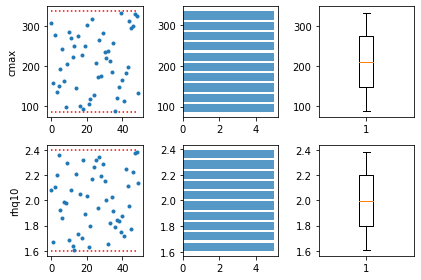

In [5]:
driver.plot_sensitivity_matrix()

### Option 2
Simply build the parameter specification by hand. The bounds are set totally manually.
> Note that a `cmtnum` is not set. This is not a problem for generating the sensitivity matrix. However it will be necessary to set a `cmtnum` before conducting runs - so that the driver knows which parameters to modify and the model knows which community type to run. Knowing the community type that was used for the run will also be necessary for processing the outputs.

In [6]:
names=['cmax','rhq10','micbnup']
pfts=[3, None, None]
bounds=[[0.,1.],[25.,60.],[.1, .4]]
driver.params = [{'name':name, 'bounds':bound, 'pft':pft} for name, bound, pft in zip(names,bounds,pfts)]
driver.sample_matrix = Sensitivity.generate_lhc(15, driver.params)
print(driver.info())


work_dir: /data/workflows/sensitivity_analysis
site: /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/
pixel(y,x): (0,0)
cmtnum: None
found 0 existing sensitivity csv files.
  > NOTE - these may be leftover from a prior run!
params:
      name        bounds  pft
0     cmax    [0.0, 1.0]  3.0
1    rhq10  [25.0, 60.0]  NaN
2  micbnup    [0.1, 0.4]  NaN
sample_matrix:
       cmax      rhq10   micbnup
0  0.510911  51.822813  0.143703
1  0.729122  33.606272  0.110838
2  0.848838  47.014597  0.297459
3  0.014329  44.241605  0.194644
4  0.402079  50.244572  0.236131


Additionally, there is a way to save the experiment. This will output 2 files, one for the parameters, and one of the sample matrix.

In [7]:
driver.save_experiment("/tmp/test_001")
!cat /tmp/test_001_param_props.csv
!cat /tmp/test_001_sample_matrix.csv

Saving /tmp/test_001_sample_matrix.csv
Saving /tmp/test_001_param_props.csv
name,bounds,pft
cmax,"[0.0, 1.0]",3.0
rhq10,"[25.0, 60.0]",
micbnup,"[0.1, 0.4]",
cmax,rhq10,micbnup
0.5109114110241766,51.82281307114779,0.14370265857677242
0.7291219826216505,33.60627225833139,0.11083801894756717
0.8488381398140167,47.01459712340874,0.29745891671752817
0.014329358572717117,44.24160474422459,0.19464449772819126
0.40207887567075234,50.24457207457313,0.23613122295722902
0.35081760295332165,57.19863705092762,0.3931756673342144
0.23967186204668367,59.28762509866033,0.3338455312903571
0.8700950542322834,25.635005320203245,0.2569839130313064
0.16642441648008244,42.71053822269454,0.20499336017718373
0.9731228565944593,37.50893909286006,0.12978849927286282
0.08894959272113072,34.547024837762145,0.36442418883639205
0.6513941469163881,41.14039834274523,0.17975336015993296
0.7404398835422514,29.985910138810908,0.31888118679373234
0.5383425187823873,29.550553825581872,0.34078853622737015
0.315212583746906

And there is a way to load an experiment design from the text files. 
> Note that the path handling could probably be improved

In [8]:
driver.load_experiment("/tmp/test_001_param_props.csv","/tmp/test_001_sample_matrix.csv")
print(driver.info())


work_dir: /data/workflows/sensitivity_analysis
site: /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/
pixel(y,x): (0,0)
cmtnum: None
found 0 existing sensitivity csv files.
  > NOTE - these may be leftover from a prior run!
params:
         name        bounds  pft
0     b'cmax'    [0.0, 1.0]  3.0
1    b'rhq10'  [25.0, 60.0]  NaN
2  b'micbnup'    [0.1, 0.4]  NaN
sample_matrix:
       cmax      rhq10   micbnup
0  0.510911  51.822813  0.143703
1  0.729122  33.606272  0.110838
2  0.848838  47.014597  0.297459
3  0.014329  44.241605  0.194644
4  0.402079  50.244572  0.236131


## Run the model over an experiment space

Now that we see a few ways to use a `SensitivityDriver` object, let's start fresh with a new driver instance, setup and execute some runs.

For this toy experiment, we are going to draw 10 sample sets across 3 parameters (2 soil parameter and one PFT parameter). We are going to use the default `percent_diffs` for generating the sample matrix: +/-10%. And we are going to be analyzing CMT 5 (Tussock Tundra).


work_dir: /data/workflows/sensitivity_analysis
site: /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/
pixel(y,x): (0,0)
cmtnum: 5
found 0 existing sensitivity csv files.
  > NOTE - these may be leftover from a prior run!
params:
      name          bounds  initial  cmtnum  pftnum
0     cmax  [405.0, 495.0]   450.00       5     3.0
1    rhq10      [1.8, 2.2]     2.00       5     NaN
2  micbnup  [0.675, 0.825]     0.75       5     NaN
sample_matrix shape: (10, 3)


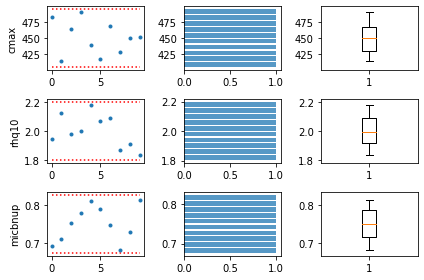

In [11]:
# Instantiate object, sets pixel, outputs, working directory, site selection (input data path)
driver = Sensitivity.SensitivityDriver()

# choose parameters, number of samples, 
driver.design_experiment(10, 5, params=['cmax', 'rhq10', 'micbnup'], pftnums=[3,None,None])
print(driver.info())
driver.plot_sensitivity_matrix()

With the experiment designed, we need to setup all the required directories, and make all the required adjustments for each run, such as:
 - enabling output variables, 
 - adjusting the run mask, 
 - adjusting the config file, and 
 - injecting the parameter values from our `sample_matrix`.

In [13]:
# makes directories, sets config files, input data, etc for each run
driver.setup_multi()

PROC:<ForkProcess name='ForkPoolWorker-9' parent=74 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-8' parent=74 started daemon>   PROC:<ForkProcess name='ForkPoolWorker-12' parent=74 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-13' parent=74 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-11' parent=74 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-14' parent=74 started daemon>   {'cmax': 413.9472542509905, 'rhq10': 2.1280373475463623, 'micbnup': 0.7109897387371397}  {'cmax': 483.02538259678374, 'rhq10': 1.9476001956328268, 'micbnup': 0.6935196312278319} {'cmax': 418.1868505105535, 'rhq10': 2.07024653315581, 'micbnup': 0.7880993569542084}
PROC:<ForkProcess name='ForkPoolWorker-10' parent=74 started daemon>  {'cmax': 468.54128108340706, 'rhq10': 2.0939028609695596, 'micbnup': 0.7476304994156463} 

 [SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/ /data/work


[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000003/config/output_spec.csv --on CMTNUM y


[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000005/config/output_spec.csv --on CMTNUM y

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000001/config/output_spec.csv --on CMTNUM y
[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000002/config/output_spec.csv --on CMTNUM y

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000006/config/output_spec.csv --on CMTNUM y


[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000004/config/output_spec.csv --on CMTNUM y

                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
                VEGC                 g/m2    


[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000008/config/output_spec.csv --on CMTNUM y

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000007/config/output_spec.csv --on CMTNUM y

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000009/config/output_spec.csv --on CMTNUM y



                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
                VEGC                 g/m2            y            m      invalid            p                   invalid       double     Total veg. biomass C
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
                VEGC                 g/m2            y            m      invalid            p                   invalid       double     To

And once the setup is complete, now we can carry out the runs. 

In [14]:
# carry out the run and do initial output collection
driver.run_all_samples()

[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 5 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000000/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 5 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000001/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 5 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000003/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 5 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000005/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 5 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000004/config/config.js
[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 5 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000002/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 5 --ctrl-fil

## Process, analyze, and plot data after runs

In [15]:
driver.extract_data_for_sensitivity_analysis()

driver.first_steps_sensitivity_analysis()

             p_cmax   p_rhq10  p_micbnup     o_GPP    o_VEGC
p_cmax     1.000000 -0.232531   0.042716  0.999934  0.999957
p_rhq10   -0.232531  1.000000   0.249154 -0.243005 -0.238276
p_micbnup  0.042716  0.249154   1.000000  0.038722  0.043406
o_GPP      0.999934 -0.243005   0.038722  1.000000  0.999959
o_VEGC     0.999957 -0.238276   0.043406  0.999959  1.000000
Make some cool plot here....


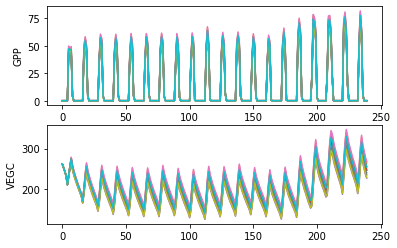

In [16]:
driver.make_cool_plot_2()

In [ ]:
def get_CMT_params(cmtnum=4,pftnum=3,perc=0.1):
    
    from collections import defaultdict
    '''
    This function gets the cmtnum and pftnum parameters from my-path-to-default/cmt_calparbgc.txt
    and sets the parameter specification. The default boundary setup is perc=+-10% from the original value

    Inputs:
        cmtnum : community type number (default=4)
        pftnum : plant functional type number (default=3)
        perc :   percent difference from the origina value (default=10%)

    Outputs:
        param_specs : paramter specifications dictionary

    Example:
       param_specs=get_CMT_params()
       for key in list(param_specs.keys()):
          print(key,':',param_specs[key])

    '''
    # Tobey consider changing param_util.py to more appropriate calling of a function from the .py file
    # change driver.work_dir to self.work_dir
    data = !param_util.py --dump-block-to-json /work/parameters/cmt_calparbgc.txt {cmtnum}
    #data = run -i param_util.py --dump-block-to-json {self.work_dir}/default_parameters/cmt_calparbgc.txt {cmtnum}
    CMT_data = json.loads(data[0])

    #choose parameters correspoding to a given pfnum
    d=pd.Series(CMT_data['pft'+str(pftnum)])
    param_specs = defaultdict()
    print('Getting parameters for PFT:',d['name'])
    for key, val in d.items():
        if key=='name':
            continue
        param_specs[key]={'val':val, 'bnds':[val-perc*val,val+perc*val], 
                          'cmtnum':cmtnum, 'pftnum':pftnum, 'opt':False }

    return param_specs

In [ ]:
param_specs=get_CMT_params(pftnum=1)
for key in list(param_specs.keys()):
   print(key,':',param_specs[key])

We want to opt in vcmax and ncmax, change the bounds, and create the sample matrix.

In [ ]:
print('Current cmax:',param_specs['cmax'])
param_specs['cmax']['bnds'][0]=param_specs['cmax']['val']-50
param_specs['cmax']['bnds'][1]=param_specs['cmax']['val']+50
param_specs['cmax']['opt']=True
print('Updated cmax:',param_specs['cmax'])

print('Current nmax:',param_specs['nmax'])
param_specs['nmax']['bnds'][0]=param_specs['nmax']['val']-3
param_specs['nmax']['bnds'][1]=param_specs['nmax']['val']+3
param_specs['nmax']['opt']=True
print('Updated nmax:',param_specs['nmax'])

In [ ]:
def create_a_sample_matrix(run_name, param_specs, method='uniform', sample_N=5):
    # Tobey: we need to add lhsmdu in the docker file
    import lhsmdu    #generate Latin Hypercube samples
    '''
    This function creates a sampling matrix and saves it into the (var_'run_name'.csv) file
    Inputs:
        run_name: for a better tracking of the tests 
        param_specs: 'lhs', 'uniform' 
        sample_N: sample size
        param_specs: parameter specification dictionary
    Outputs:
        sample_matrix : the ( sample_N,len(sens_params) ) sample matrix 
    '''
    # 1. Create the sens_params dictionary that includes only opt-in values
    sens_params={}
    for key in list(param_specs.keys()):
        if param_specs[key]['opt']==True:
            sens_params[key]=param_specs[key]

    # 2. Select low boundaries from the sens_params dict. and calculate the difference
    val_low_bnd = [sens_params[key]['bnds'][0] for key in list(sens_params.keys())]
    val_diff = [sens_params[key]['bnds'][1]-sens_params[key]['bnds'][0] for key in list(sens_params.keys())]
    
    # 3. Choose sampling method: lhs or uniform
    if method == 'lhs':
        # Latin Hypercube Sampling, each column indicates a sample point
        # This is like an initialization, almost return the same results

        #Need to add lhsmdu in the docker file
        l = lhsmdu.sample(len(sens_params),sample_N)    #type:matrix
        # Latin Hypercube Sampling of factor(influent or parameter or ic)
        l = lhsmdu.resample().T        # Latin Hypercube Sampling from uniform, after transpose, each row indicates a sample point
        mat_diff = np.diag(val_diff)
        sample_matrix = l*mat_diff + val_low_bnd      # Scaling to Latin Hypercube Sampling of influent
                
    elif method == 'uniform':
        ## Uniform Sampling ##
        l = np.random.uniform(size=(sample_N, len(sens_params)))
        sample_matrix = l*val_diff + val_low_bnd

    np.savetxt('var_%s.csv'%(run_name),sample_matrix,delimiter=',',fmt='%13.5f')
    print ('Saves a sampling matrix [sample_size,array_size] into var_%s.csv'%(run_name))
    print ('sample_size,array_size: ',sample_matrix.shape)
    print ('Each column of the matrix corresponds to a variable perturbed 100 times around its original value ')
    print ('var_%s.csv'%(run_name), 'SAVED!')
    
    return sample_matrix

In [ ]:
create_a_sample_matrix('test_run001',param_specs)